# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import spacy

## Load Data

In [2]:
# Load data
df = pd.read_csv(
    'data/reviews.csv',
)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


In [3]:
df.head(8)

,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name,Recommended IND
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses,0
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants,1
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses,1
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses,0
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits,1
5,858,39,"Shimmer, surprisingly goes with lots","I ordered this in carbon for store pick up, an...",4,General Petite,Tops,Knits,1
6,1077,24,Flattering,I love this dress. i usually get an xs but it ...,0,General,Dresses,Dresses,1
7,1077,34,Such a fun dress!,"I'm 5""5' and 125 lbs. i ordered the s petite t...",0,General,Dresses,Dresses,1


In [4]:
df.describe()

,Clothing ID,Age,Positive Feedback Count,Recommended IND
count,18442.000000,18442.000000,18442.000000,18442.000000
mean,954.896757,43.383635,2.697484,0.816235
std,141.571783,12.246264,5.942220,0.387303
min,2.000000,18.000000,0.000000,0.000000
25%,863.000000,34.000000,0.000000,1.000000
50%,952.000000,41.000000,1.000000,1.000000
75%,1078.000000,52.000000,3.000000,1.000000
max,1205.000000,99.000000,122.000000,1.000000


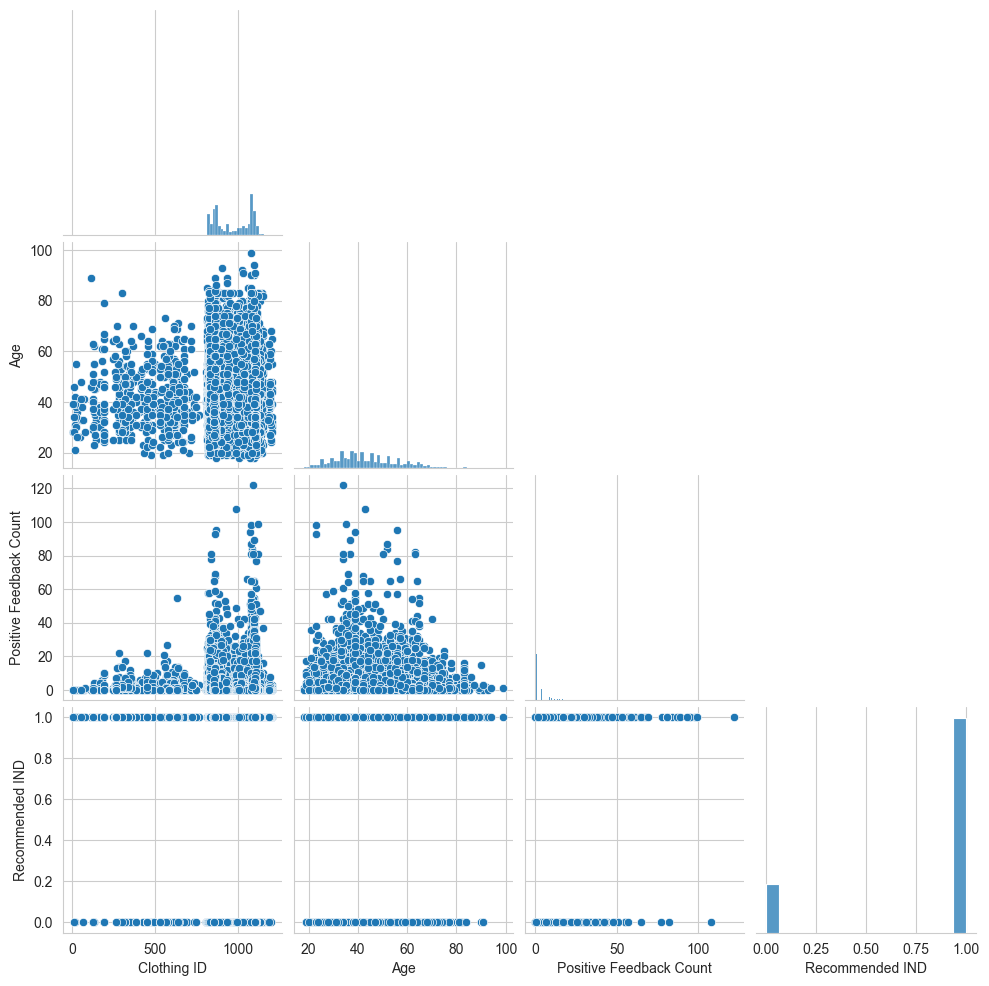

In [5]:
sns.pairplot(df, corner=True)
plt.show()

## Preparing features (`X`) & target (`y`)

In [6]:
data = df

# separate features from labels
X = data.drop('Recommended IND', axis=1)
y = data['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


In [7]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    shuffle=True,
    random_state=27,
)

# Your Work

## Data Exploration

C:\Users\felix\AppData\Local\Temp\ipykernel_37488\2435563858.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels, rotation=45, ha='right')
C:\Users\felix\AppData\Local\Temp\ipykernel_37488\2435563858.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels, rotation=45, ha='right')
C:\Users\felix\AppData\Local\Temp\ipykernel_37488\2435563858.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(tick_labels, rotation=45, ha='right')


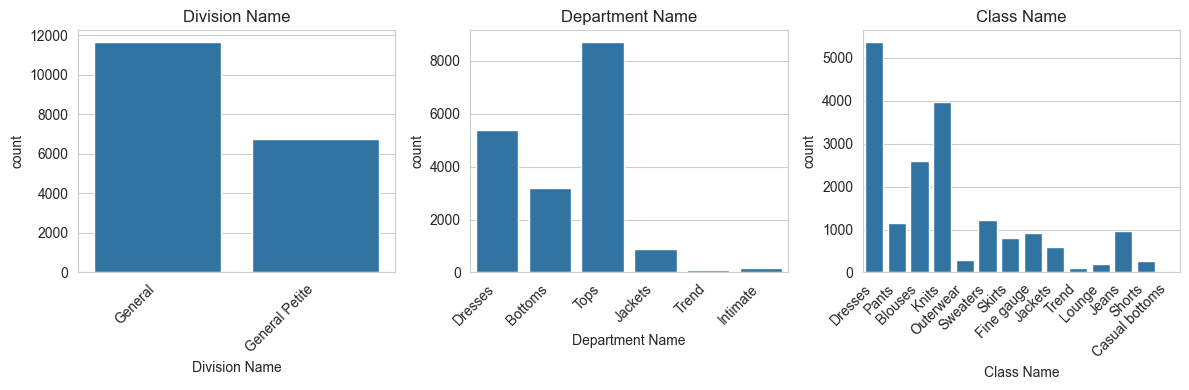

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))
sns.countplot(data=X, x='Division Name', ax=ax1)
sns.countplot(data=X, x='Department Name', ax=ax2)
sns.countplot(data=X, x='Class Name', ax=ax3)

titles = ['Division Name', 'Department Name', 'Class Name']
for ii, ax in enumerate([ax1, ax2, ax3]):
    ax.set_title(titles[ii])
    tick_labels = ax.get_xticklabels()
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

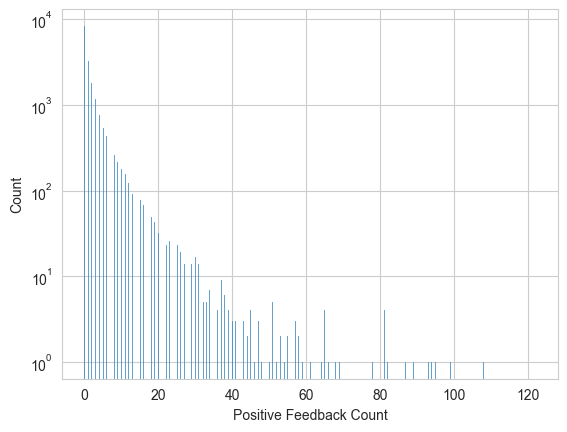

In [9]:
sns.histplot(data=df, x='Positive Feedback Count')
plt.yscale('log')
plt.show()

In [10]:
X[['Clothing ID', 'Positive Feedback Count']].duplicated().sum()

np.int64(15382)

In [11]:
X[['Clothing ID', 'Positive Feedback Count']]

,Clothing ID,Positive Feedback Count
0,1077,0
1,1049,0
2,847,6
3,1080,4
4,858,1
...,...,...
18437,1104,0
18438,862,0
18439,1104,1
18440,1084,2


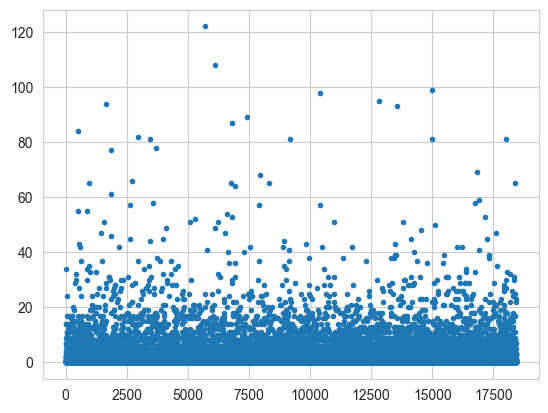

In [12]:
plt.plot(df.index, df['Positive Feedback Count'], '.')
plt.show()

## Building Pipeline

In [13]:
# Set non-text, non-num cols to categorical
for col in ['Division Name', 'Department Name', 'Class Name']:
    X[col] = X[col].astype('category')

In [14]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Clothing ID              18442 non-null  int64   
 1   Age                      18442 non-null  int64   
 2   Title                    18442 non-null  object  
 3   Review Text              18442 non-null  object  
 4   Positive Feedback Count  18442 non-null  int64   
 5   Division Name            18442 non-null  category
 6   Department Name          18442 non-null  category
 7   Class Name               18442 non-null  category
dtypes: category(3), int64(3), object(2)
memory usage: 775.5+ KB


Define numerical, categorical, and text features

In [15]:
num_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = ['Division Name', 'Department Name', 'Class Name']
text_features = X.select_dtypes(include=[object]).columns.tolist()

print("Numerical features: ", num_features)
print("Categorical features: ", cat_features)
print("Text features: ", text_features)

Numerical features:  ['Clothing ID', 'Age', 'Positive Feedback Count']
Categorical features:  ['Division Name', 'Department Name', 'Class Name']
Text features:  ['Title', 'Review Text']


#### Numerical pipeline

In [16]:
num_pipeline = Pipeline([('SimpleImputer', SimpleImputer(strategy='median')),
                         ('MinMaxScaler', MinMaxScaler())
                        ])
num_pipeline

Pipeline(steps=[('SimpleImputer', SimpleImputer(strategy='median')),
                ('MinMaxScaler', MinMaxScaler())])

#### Categorical pipeline

In [17]:
cat_pipeline = Pipeline([
    ('ordinal_encoder',
     OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse_output=False, handle_unknown='ignore')),
])

cat_pipeline

Pipeline(steps=[('ordinal_encoder',
                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                unknown_value=-1)),
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('cat_encoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

#### Text Feature Pipeline

In [18]:
nlp = spacy.load('en_core_web_sm')


In [19]:
class CountCharacter(BaseEstimator, TransformerMixin):
    def __init__(self, character: str):
        self.character = character

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [[text.count(self.character)] for text in X]


In [20]:
initial_text_preprocess = Pipeline([
    ('dimension_reshaper', FunctionTransformer(np.reshape, kw_args={'newshape':-1}))
])

feature_engineering = FeatureUnion([
    ('count_spaces', CountCharacter(character=' ')),
    ('count_exclamations', CountCharacter(character='!')),
    ('count_question_marks', CountCharacter(character='?')),
])

character_counts_pipeline = Pipeline([
    ('initial_text_preprocess', initial_text_preprocess),
    ('feature_engineering', feature_engineering),
])
character_counts_pipeline


Pipeline(steps=[('initial_text_preprocess',
                 Pipeline(steps=[('dimension_reshaper',
                                  FunctionTransformer(func=<function reshape at 0x000001677B7618F0>,
                                                      kw_args={'newshape': -1}))])),
                ('feature_engineering',
                 FeatureUnion(transformer_list=[('count_spaces',
                                                 CountCharacter(character=' ')),
                                                ('count_exclamations',
                                                 CountCharacter(character='!')),
                                                ('count_question_marks',
                                                 CountCharacter(character='?'))]))])

In [21]:
class SpacyLemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        lemmatized = [
            ' '.join(
                token.lemma_ for token in doc
                if not token.is_stop
            )
            for doc in self.nlp.pipe(X)
        ]
        return lemmatized


class SpacyPOSTagger(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [" ".join([token.pos_ for token in self.nlp(doc)]) for doc in X]


class SpacyNERExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, nlp):
        self.nlp = nlp

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [" ".join([ent.label_ for ent in self.nlp(doc).ents]) for doc in X]


In [22]:
# Build sub-pipelines for each type of feature
lemma_pipeline = Pipeline([
    ('lemmatizer', SpacyLemmatizer(nlp=nlp)),
    ('tfidf', TfidfVectorizer())
])

pos_pipeline = Pipeline([
    ('pos_extractor', SpacyPOSTagger(nlp=nlp)),
    ('tfidf', TfidfVectorizer())
])

ner_pipeline = Pipeline([
    ('ner_extractor', SpacyNERExtractor(nlp=nlp)),
    ('tfidf', TfidfVectorizer())
])

In [23]:
tfidf_feature_engineering = FeatureUnion([
    ('lemma_pipeline', lemma_pipeline),
    ('pos_pipeline', pos_pipeline),
    ('ner_pipeline', ner_pipeline),
])

tfidf_pipeline = Pipeline([
    ('initial_text_preprocess', initial_text_preprocess),
    ('feature_engineering', tfidf_feature_engineering),
])
tfidf_pipeline

Pipeline(steps=[('initial_text_preprocess',
                 Pipeline(steps=[('dimension_reshaper',
                                  FunctionTransformer(func=<function reshape at 0x000001677B7618F0>,
                                                      kw_args={'newshape': -1}))])),
                ('feature_engineering',
                 FeatureUnion(transformer_list=[('lemma_pipeline',
                                                 Pipeline(steps=[('lemmatizer',
                                                                  SpacyLemmatizer(nlp=<spacy.lang.en.English object at 0x0000016720363EF0>)),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('pos_pipeline',
                                                 Pipeline(steps=[('pos_extractor',
                                                                  SpacyPOSTagger(nlp=<spacy.lang.en.English object at 0x0000016720363EF0>)),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())])),
                                                ('ner_pipeline',
                                                 Pipeline(steps=[('ner_extractor',
                                                                  SpacyNERExtractor(nlp=<spacy.lang.en.English object at 0x0000016720363EF0>)),
                                                                 ('tfidf',
                                                                  TfidfVectorizer())]))]))])

#### Combine feature engineering pipelines

In [24]:
feature_engineering = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features),
    ('character_counts', character_counts_pipeline, text_features),
    ('tfidf_text', tfidf_pipeline, text_features),
])

feature_engineering

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('SimpleImputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('MinMaxScaler',
                                                  MinMaxScaler())]),
                                 ['Clothing ID', 'Age',
                                  'Positive Feedback Count']),
                                ('cat',
                                 Pipeline(steps=[('ordinal_encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 (...
                                                                                                   TfidfVectorizer())])),
                                                                                 ('pos_pipeline',
                                                                                  Pipeline(steps=[('pos_extractor',
                                                                                                   SpacyPOSTagger(nlp=<spacy.lang.en.English object at 0x0000016720363EF0>)),
                                                                                                  ('tfidf',
                                                                                                   TfidfVectorizer())])),
                                                                                 ('ner_pipeline',
                                                                                  Pipeline(steps=[('ner_extractor',
                                                                                                   SpacyNERExtractor(nlp=<spacy.lang.en.English object at 0x0000016720363EF0>)),
                                                                                                  ('tfidf',
                                                                                                   TfidfVectorizer())]))]))]),
                                 ['Title', 'Review Text'])])

#### Building classifier pipeline
Try out different pipelines with increasing complexity

##### Logistic Regression

In [27]:
clf_logreg = Pipeline([('feature_engineering', feature_engineering),
                       ('logreg', LogisticRegression(penalty='l2',))
                       ])


In [28]:
clf_svm = Pipeline([('feature_engineering', feature_engineering),
                    ('svm', SVC(C=1.0, kernel='linear', random_state=42)),
                    ])


In [29]:
clf_random_forest = Pipeline([
    ('feature_engineering', feature_engineering),
    ('random_forest', RandomForestClassifier(random_state=42))
])


## Training Pipeline

## Fine-Tuning Pipeline